In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from hs2 import herdingspikes
from Probe import NeuralProbe, NeuroPixel
import numpy as np

%matplotlib inline

In [2]:
# data = h5py.File(data_path, 'r')
# data = np.fromfile(data_path, dtype=np.int16).reshape((1800000,385))

H = herdingspikes()

You can now load your data in three ways: with LoadDetected()
        (automatically loads ProcessedSpikes, neighbormatrix and positions);
        with DetectFromRaw (takes a path to the raw data and all detection
        parameters) or with LoadH5 (takes a previously saved instance of
        this class)


In [3]:
Probe = NeuralProbe(num_channels=385, spike_delay=5,
        			spike_peak_duration=5, noise_duration=3,
        			noise_amp = 80000, fps=30000, 
                    positions_file_path='positions', 
                    neighbors_file_path='neighbormatrix')

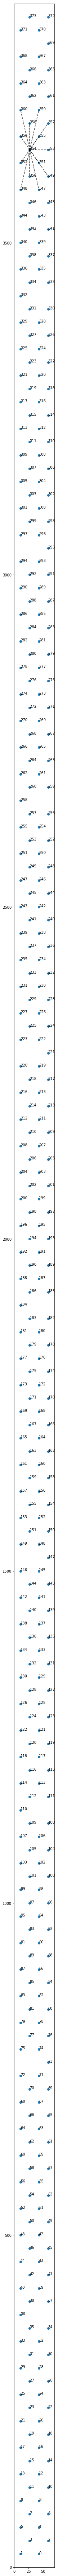

In [4]:
Probe.show(figwidth=2, show_neighbors=[-20])

In [5]:
NeuroPixelProbe = NeuroPixel()

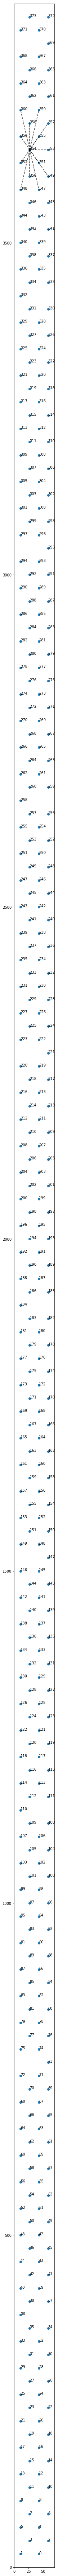

In [6]:
NeuroPixelProbe.show(figwidth=2, show_neighbors=[-20])

In [9]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

data_path = '/home/cole/neuropixeldata/rawDataSample.bin'
to_localize = True
cutout_length = 40
threshold = 20 #20

In [12]:
H.DetectFromRaw(data_path, NeuroPixelProbe,
                to_localize, cutout_length, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0)

# # OR

H.LoadDetected(NeuroPixelProbe)

# Sampling rate: 30000
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
tInc:100000
Analysing 100000 frames; -42 100055
t0 = 0, t1 = 100000
Analysing 100000 frames; 99958 200055
t0 = 100000, t1 = 200000
Analysing 100000 frames; 199958 300055
t0 = 200000, t1 = 300000
Analysing 100000 frames; 299958 400055
t0 = 300000, t1 = 400000
Analysing 100000 frames; 399958 500055
t0 = 400000, t1 = 500000
Analysing 100000 frames; 499958 600055
t0 = 500000, t1 = 600000
Analysing 100000 frames; 599958 700055
t0 = 600000, t1 = 700000
Analysing 100000 frames; 699958 800055
t0 = 700000, t1 = 800000
Analysing 100000 frames; 799958 900055
t0 = 800000, t1 = 900000
Analysing 100000 frames; 899958 1000055
t0 = 900000, t1 = 1000000
Analysing 100000 frames; 999958 1100055
t0 = 1000000, t1 = 1100000
Analysing 100000 frames; 1099958 1200055
t0 = 1100000, t1 = 1200000
Analysing 100000 frames; 1199958 1300055
t0 = 12000

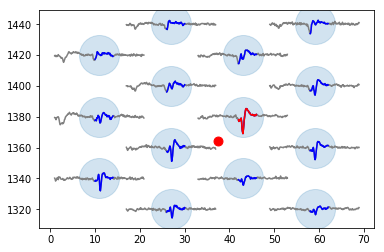

In [16]:
H.PlotTracesChannels(data_path, 1011)

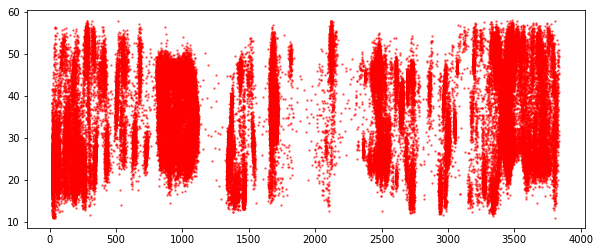

In [17]:
plt.figure(figsize=(10, 4))
H.PlotAll(invert=True, s=2, alpha=0.5)

In [18]:
H.CombinedClustering(alpha=40,
                    bandwidth = 20, bin_seeding=True, min_bin_freq=10,
                    pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

('Number of estimated clusters:', 165)


In [ ]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=10)
plt.xlim((1350,1600))
plt.title("MeanShift, bandwidth=20, min_bin_freq=10")

In [23]:
from sklearn.cluster import DBSCAN
H.CombinedClustering(eps=8, alpha=40, clustering_algorithm=DBSCAN,
                    min_samples=5, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

('Number of estimated clusters:', 459)


(1350, 1600)

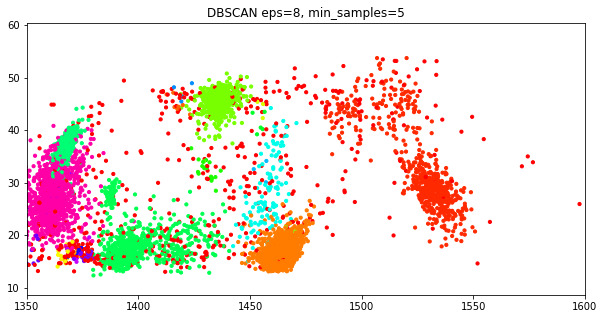

In [24]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=10)
plt.title("DBSCAN eps=8, min_samples=5")
plt.xlim((1350,1600))


In [26]:
units = (121,4)

H.PlotShapes(units)

ValueError: num must be 1 <= num <= 0, not 1